In [7]:
import pandas as pd
import numpy as np
data = pd.read_csv("EXKOUS.csv")
tsValues = data['EXKOUS']
import math
tsValuesLog = [math.log(ele) for ele in tsValues]

In [13]:
startPrediction = 80

In [14]:
totalData = 120

In [15]:
totalData

120

In [11]:
from matplotlib import pyplot as plt

In [16]:
tsValuesLog = tsValuesLog[-120:]

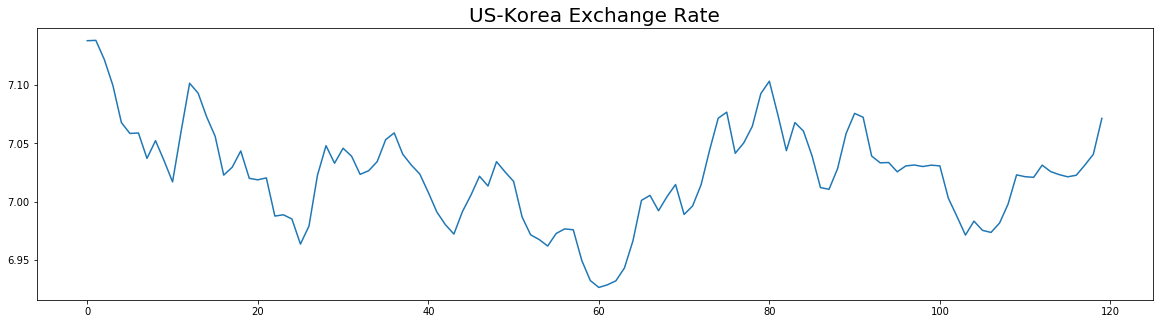

In [17]:
plt.figure(figsize=(20,5))
plt.plot(tsValuesLog)
plt.title("US-Korea Exchange Rate",fontsize=20)
plt.show()

In [18]:
def mean_error(pred,real):
    return np.mean([pred[i]-real[i] for i in range(len(pred))])
def mean_absolute_error(pred,real):
    return np.mean([np.abs(pred[i]-real[i]) for i in range(len(pred))])
def root_mean_square_error(pred,real):
    return np.sqrt(np.mean([pow(pred[i]-real[i],2) for i in range(len(pred))]))

In [19]:
PredictionOutputMAE = pd.DataFrame(index=['monthly','3_month','6_month','12_month'])
PredictionOutputRMSE = pd.DataFrame(index=['monthly','3_month','6_month','12_month'])

In [20]:
#benchmark
mae_ = []
rmse_ = []
for l in [1,3,6,12]:
    pred = [0]*(startPrediction+l-1)
    for i in range(totalData-startPrediction-l+1):
        pred.append(tsValuesLog[startPrediction-1+i])
    mae_.append(mean_absolute_error(pred[startPrediction+l-1:],tsValuesLog[startPrediction+l-1:]))
    rmse_.append(root_mean_square_error(pred[startPrediction+l-1:],tsValuesLog[startPrediction+l-1:]))
PredictionOutputMAE['RandomWalk'] = mae_
PredictionOutputRMSE['RandomWalk'] = rmse_

In [21]:
PredictionOutputMAE

,RandomWalk
monthly,0.012004
3_month,0.023848
6_month,0.031978
12_month,0.039426


In [22]:
#LSTM Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import random
#LSTMModel
class LstmModel:
    def __init__(self, lstm_cells_per_layer_used=100, loss_used='mean_squared_error', optimizer_used='adam', epochs_used=100, batch_size_used=5, random_seed_used=1, sample_num=5, feature_length_used=5):
        self.model_name = 'LSTM_{}_{}_Model'.format(sample_num, feature_length_used)
        self.lstm_cells_per_layer_used = lstm_cells_per_layer_used
        self.loss_used = loss_used
        self.optimizer_used = optimizer_used
        self.epochs_used = epochs_used
        self.batch_size_used = batch_size_used
        self.model = None
        
        self.random_seed_used = random_seed_used
        np.random.seed(self.random_seed_used)
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        
        self.data_ori = None
        self.sample_num = sample_num
        self.feature_length_used = feature_length_used
        
        return
    
    def fit(self, data):
        keras.backend.clear_session()
        #sess = tf.Session(config=tf.ConfigProto(device_count={'gpu':0}))
        self.data_ori = data
        if len(self.data_ori) <= 1:
            self.model = None
            return
        
        self.sample_num = min(self.sample_num, len(self.data_ori))
        self.feature_length_used = min(self.feature_length_used, len(self.data_ori) - self.sample_num)
        
        if self.feature_length_used <= 0:
            self.sample_num -= 1
            self.feature_length_used = 1
            if self.sample_num <= 0:
                raise Exception('Insufficient data!')

        self.data = np.array(self.data_ori)[-(self.sample_num+self.feature_length_used):]
        self.data = self.data.astype(np.float64)
        self.data = self.scaler.fit_transform(self.data.reshape(-1, 1)).T[0]
        
        x_train, y_train = [], []
        for i in range(0, self.sample_num):
            feature_vec = []
            label_val = self.data[len(self.data) - self.sample_num + i]
            for j in range(0, self.feature_length_used):
                val = self.data[len(self.data) - self.sample_num - self.feature_length_used + i + j]
                feature_vec.append(val)
            x_train.append(feature_vec)
            y_train.append(label_val)
            
        x_train = np.array(x_train)
        y_train = np.array(y_train)
        
        x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
        
        self.model = Sequential()
        self.model.add(LSTM(self.lstm_cells_per_layer_used, input_shape=(1, self.feature_length_used)))
        self.model.add(Dense(1))
        self.model.compile(loss=self.loss_used, optimizer=self.optimizer_used)
        verbose_used = 0
        self.model.fit(x_train, y_train, epochs=self.epochs_used, batch_size=self.batch_size_used, verbose=verbose_used)
        
        return
        
    
    def predict(self, next_n_prediction):
        pred = []
        if self.model == None:
            if len(self.data_ori) <= 0:
                pred = [np.nan, ] * next_n_prediction
            else:
                pred = [self.data_ori[-1], ] * next_n_prediction
            return pred

        rest_prediction_num = next_n_prediction
        round_num = 0
        while rest_prediction_num > 0:
            x_test = []
            feature_vec = []
            for i in range(0, self.feature_length_used):
                val = self.data[self.sample_num+i+round_num]
                feature_vec.append(val)
            x_test.append(feature_vec)
            
            x_test = np.array(x_test)
            x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
            
            predict_test = self.model.predict(x_test)
            
            predict_test_scaled = predict_test
            predict_test_scaled = [item[0] for item in predict_test_scaled]
            predict_test_scaled = np.array(predict_test_scaled)
            predict_test_scaled = predict_test_scaled.astype(np.float64)
            self.data = np.append(self.data, predict_test_scaled)
            
            predict_test = self.scaler.inverse_transform(predict_test)
            predict_test = [item[0] for item in predict_test]
            
            
            pred += predict_test
            
            round_num += 1
            rest_prediction_num -= len(predict_test)
        
        pred = pred[0:next_n_prediction]
        pred_pre = np.array(pred)
        pred_pre = pred_pre.astype(np.float64)
        pred = list(pred_pre)
        return pred

Using TensorFlow backend.


In [23]:
import keras

In [24]:
import keras.backend

In [25]:
import time
for feature_len in [1,2]:
    mae_ = []
    rmse_ = []
    start = time.time()
    for l in [1,3,6,12]:
        pred = [0]*(startPrediction+l-1)
        for i in range(totalData-startPrediction-(l-1)):
            model = LstmModel(sample_num=100-feature_len,feature_length_used=feature_len)
            model.fit(tsValuesLog[i:i+startPrediction])
            pred.append(model.predict(l)[l-1])
            #print(i,"end")
        mae = mean_absolute_error(pred[startPrediction+l-1:],tsValuesLog[startPrediction+l-1:])
        rmse = root_mean_square_error(pred[startPrediction+l-1:],tsValuesLog[startPrediction+l-1:])
        print(mae,rmse)
        mae_.append(mae)
        rmse_.append(rmse)
    end = time.time()
    print(time)
    name = 'LSTM_'+str(100-feature_len)+str(feature_len)
    PredictionOutputMAE[name] = mae_
    PredictionOutputRMSE[name] = rmse_

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
0.011657263483624235 0.015229235887812298
0.020687432999723053 0.02686088565046849
0.02380068326987124 0.027904437535015265
0.023985165533573216 0.02866773185734338
<module 'time' (built-in)>
0.011657263483624235 0.015229111773322177
0.020687934933573793 0.026861399368520642
0.023800901252572133 0.02790427098577016
0.02398437628586309 0.028667778840138127
<module 'time' (built-in)>


In [26]:
#LSTM Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import random
#LSTMModel
class LstmModel:
    def __init__(self, lstm_cells_per_layer_used=100, loss_used='mean_absolute_error', optimizer_used='adam', epochs_used=100, batch_size_used=5, random_seed_used=1, sample_num=5, feature_length_used=5):
        self.model_name = 'LSTM_{}_{}_Model'.format(sample_num, feature_length_used)
        self.lstm_cells_per_layer_used = lstm_cells_per_layer_used
        self.loss_used = loss_used
        self.optimizer_used = optimizer_used
        self.epochs_used = epochs_used
        self.batch_size_used = batch_size_used
        self.model = None
        
        self.random_seed_used = random_seed_used
        np.random.seed(self.random_seed_used)
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        
        self.data_ori = None
        self.sample_num = sample_num
        self.feature_length_used = feature_length_used
        
        return
    
    def fit(self, data):
        keras.backend.clear_session()
        #sess = tf.Session(config=tf.ConfigProto(device_count={'gpu':0}))
        self.data_ori = data
        if len(self.data_ori) <= 1:
            self.model = None
            return
        
        self.sample_num = min(self.sample_num, len(self.data_ori))
        self.feature_length_used = min(self.feature_length_used, len(self.data_ori) - self.sample_num)
        
        if self.feature_length_used <= 0:
            self.sample_num -= 1
            self.feature_length_used = 1
            if self.sample_num <= 0:
                raise Exception('Insufficient data!')

        self.data = np.array(self.data_ori)[-(self.sample_num+self.feature_length_used):]
        self.data = self.data.astype(np.float64)
        self.data = self.scaler.fit_transform(self.data.reshape(-1, 1)).T[0]
        
        x_train, y_train = [], []
        for i in range(0, self.sample_num):
            feature_vec = []
            label_val = self.data[len(self.data) - self.sample_num + i]
            for j in range(0, self.feature_length_used):
                val = self.data[len(self.data) - self.sample_num - self.feature_length_used + i + j]
                feature_vec.append(val)
            x_train.append(feature_vec)
            y_train.append(label_val)
            
        x_train = np.array(x_train)
        y_train = np.array(y_train)
        
        x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
        
        self.model = Sequential()
        self.model.add(LSTM(self.lstm_cells_per_layer_used, input_shape=(1, self.feature_length_used)))
        self.model.add(Dense(1))
        self.model.compile(loss=self.loss_used, optimizer=self.optimizer_used)
        verbose_used = 0
        self.model.fit(x_train, y_train, epochs=self.epochs_used, batch_size=self.batch_size_used, verbose=verbose_used)
        
        return
        
    
    def predict(self, next_n_prediction):
        pred = []
        if self.model == None:
            if len(self.data_ori) <= 0:
                pred = [np.nan, ] * next_n_prediction
            else:
                pred = [self.data_ori[-1], ] * next_n_prediction
            return pred

        rest_prediction_num = next_n_prediction
        round_num = 0
        while rest_prediction_num > 0:
            x_test = []
            feature_vec = []
            for i in range(0, self.feature_length_used):
                val = self.data[self.sample_num+i+round_num]
                feature_vec.append(val)
            x_test.append(feature_vec)
            
            x_test = np.array(x_test)
            x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
            
            predict_test = self.model.predict(x_test)
            
            predict_test_scaled = predict_test
            predict_test_scaled = [item[0] for item in predict_test_scaled]
            predict_test_scaled = np.array(predict_test_scaled)
            predict_test_scaled = predict_test_scaled.astype(np.float64)
            self.data = np.append(self.data, predict_test_scaled)
            
            predict_test = self.scaler.inverse_transform(predict_test)
            predict_test = [item[0] for item in predict_test]
            
            
            pred += predict_test
            
            round_num += 1
            rest_prediction_num -= len(predict_test)
        
        pred = pred[0:next_n_prediction]
        pred_pre = np.array(pred)
        pred_pre = pred_pre.astype(np.float64)
        pred = list(pred_pre)
        return pred

In [27]:
import time
for feature_len in [1,2]:
    mae_ = []
    rmse_ = []
    start = time.time()
    for l in [1,3,6,12]:
        pred = [0]*(startPrediction+l-1)
        for i in range(totalData-startPrediction-(l-1)):
            model = LstmModel(sample_num=100-feature_len,feature_length_used=feature_len)
            model.fit(tsValuesLog[i:i+startPrediction])
            pred.append(model.predict(l)[l-1])
            #print(i,"end")
        mae = mean_absolute_error(pred[startPrediction+l-1:],tsValuesLog[startPrediction+l-1:])
        rmse = root_mean_square_error(pred[startPrediction+l-1:],tsValuesLog[startPrediction+l-1:])
        print(mae,rmse)
        mae_.append(mae)
        rmse_.append(rmse)
    end = time.time()
    print(time)
    name = 'LSTM_mae_'+str(100-feature_len)+str(feature_len)
    PredictionOutputMAE[name] = mae_
    PredictionOutputRMSE[name] = rmse_

0.011962941752000767 0.015536751490796898
0.02030117582403051 0.02735830193256844
0.02526299297097336 0.030833902420831377
0.030980288677340876 0.03480039640723267
<module 'time' (built-in)>
0.012077147986916437 0.015662631397440268
0.020552584094015936 0.02746567671465243
0.024964763358196786 0.03029316535652704
0.03078037880942937 0.035199816808213026
<module 'time' (built-in)>


In [30]:
PredictionOutputMAE.to_csv("Network_LSTM_mae_mae_KO.csv")

In [31]:
PredictionOutputRMSE.to_csv("Network_LSTM_mae_rmse_KO.csv")

In [28]:
PredictionOutputMAE

,RandomWalk,LSTM_991,LSTM_982,LSTM_mae_991,LSTM_mae_982
monthly,0.012004,0.011657,0.011657,0.011963,0.012077
3_month,0.023848,0.020687,0.020688,0.020301,0.020553
6_month,0.031978,0.023801,0.023801,0.025263,0.024965
12_month,0.039426,0.023985,0.023984,0.030980,0.030780


In [29]:
PredictionOutputRMSE

,RandomWalk,LSTM_991,LSTM_982,LSTM_mae_991,LSTM_mae_982
monthly,0.015985,0.015229,0.015229,0.015537,0.015663
3_month,0.031091,0.026861,0.026861,0.027358,0.027466
6_month,0.038814,0.027904,0.027904,0.030834,0.030293
12_month,0.047707,0.028668,0.028668,0.034800,0.035200
